In [1]:
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.metrics import *
from keras.optimizers import *
from keras.applications import *
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import random

from flask import Flask, render_template, request
import os

In [16]:


trainDataset = ['deployment/DATA/Training/']
testDataset = ['deployment/DATA/Testing/']

trainPaths = []
trainLables = []

for trainDir in trainDataset:
    for label in os.listdir(trainDir):
        for image in os.listdir(trainDir+label):
            trainPaths.append(trainDir+label+'/'+image)
            trainLables.append(label)

trainPaths, trainLables = shuffle(trainPaths, trainLables)

testPaths = []
testLables = []

for testDir in testDataset:
    for label in os.listdir(testDir):
        for image in os.listdir(testDir+label):
            testPaths.append(testDir+label+'/'+image)
            testLables.append(label)

testPaths, testLables = shuffle(testPaths, testLables)
uniqueLables = os.listdir(trainDir)


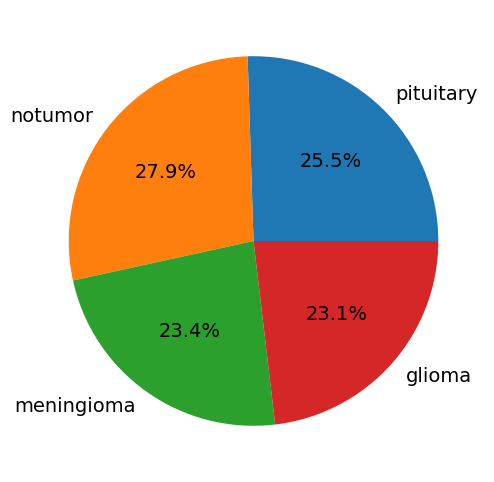

In [17]:
plt.figure(figsize=(14,6))
plt.rcParams.update({'font.size': 14})
plt.pie(
    [
        len([x for x in trainLables if x == 'pituitary']),
        len([x for x in trainLables if x == 'notumor']),
        len([x for x in trainLables if x == 'meningioma']),
        len([x for x in trainLables if x == 'glioma'])
    ],
    labels=['pituitary','notumor', 'meningioma', 'glioma'],
    autopct='%.1f%%'
);

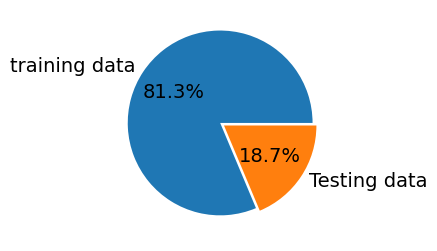

In [19]:
plt.figure(figsize=(3,3))
plt.pie(
    [len(trainLables), len(test_labels)],
    labels=['training data','Testing data'],
    autopct='%.1f%%', explode=(0.05,0),
);

In [20]:
agu = 0.5
def augmentImages(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(1-agu,1+agu))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(1-agu,1+agu))
    image = ImageEnhance.Sharpness(image).enhance(random.uniform(1-agu,1+agu))
    
    image = np.array(image)/255.0
    return image
    

In [21]:
from PIL import Image, ImageFilter
import PIL
import matplotlib.pylot as plt

In [13]:
im = PIL.Image.open('./lenna.png')


im = ImageEnhance.Brightness(image).enhance(random.uniform(1-agu,1+agu))
im = ImageEnhance.Contrast(image).enhance(random.uniform(1-agu,1+agu))
im = ImageEnhance.Sharpness(image).enhance(random.uniform(1-agu,1+agu))

fg = plt.figure(figsize=(4,4))
fg.add_subplot(111)
plt.axis("off")
plt.imshow(im)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: './lenna.png'

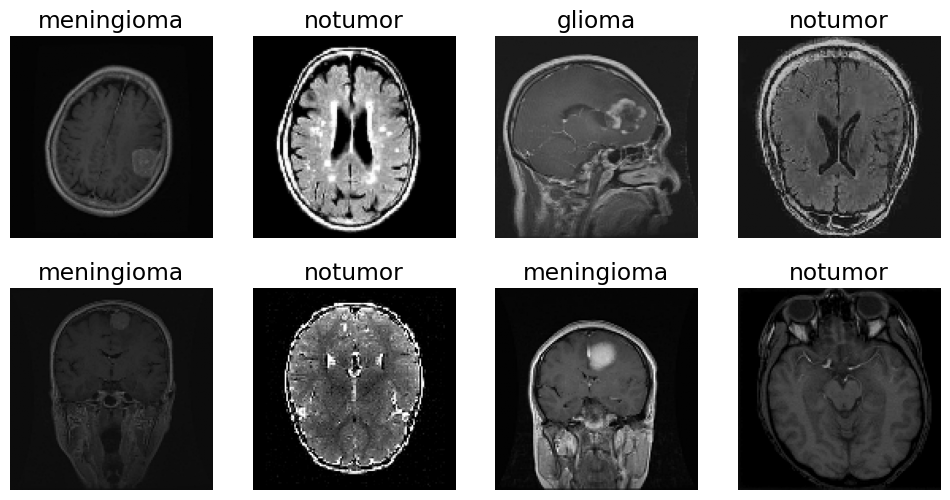

In [22]:
imageSize = 128

def openImages(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(imageSize,imageSize))
        image = augmentImages(image)
        images.append(image)
    return np.array(images)


images = openImages(trainPaths[40:49])
lbl = trainLables[40:49]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(lbl[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [23]:
uniqueLables = os.listdir(trainDir)

def encodeLables(labels):
    encoded = []
    for x in labels:
        encoded.append(uniqueLables.index(x))
    return np.array(encoded)

def decodeLables(labels):
    decoded = []
    for x in labels:
        decoded.append(uniqueLables[x])
    return np.array(decoded)


def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = openImages(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encodeLables(batch_labels)
            yield batch_images, batch_labels

In [24]:
import tensorflow as tf

In [26]:
model = tf.keras.models.load_model('model.keras')

In [9]:
baseModel = VGG16(input_shape=(imageSize,imageSize,3), include_top=False, weights='imagenet')
for layer in baseModel.layers:
    layer.trainable = False
# Set the last vgg block to trainable
baseModel.layers[-2].trainable = True
baseModel.layers[-3].trainable = True
baseModel.layers[-4].trainable = True


model = Sequential()
model.add(Input(shape=(imageSize,imageSize,3)))
model.add(baseModel)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(uniqueLables), activation='softmax'))


In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15763908 (60.13 MB)
Trainable params: 8128

In [11]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [12]:
batchSize = 25
steps = int(len(trainPaths)/batchSize)
epochs = 1
history = model.fit(datagen(trainPaths, trainLables, batchSize=batchSize, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)


ValueError: Unexpected value for `steps_per_epoch`. Received value is 0. Please check the docstring for `model.fit()` for supported values.

In [17]:
model.save("model.keras")
print("MAKE SURE ITS IN THE RIGHT PLACE")


NameError: name 'history' is not defined

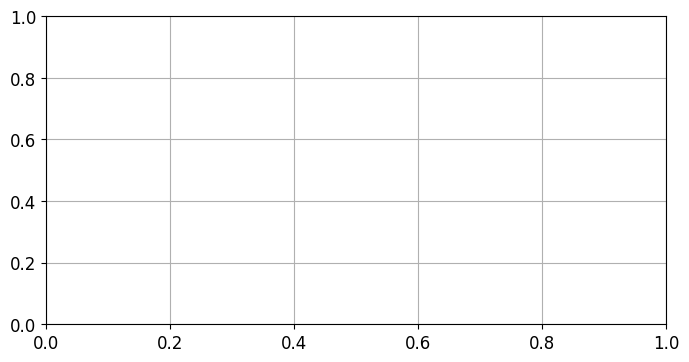

In [28]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


In [29]:
steps = int(len(testPaths)/batchSize)
yPred = []
yTrue = []
for x,y in tqdm(datagen(testPaths, testLables, batchSize=batchSize, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decodeLables(pred):
        yPred.append(i)
    for i in decodeLables(y):
        yTrue.append(i)

  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  2%|▎         | 1/40 [00:01<01:08,  1.75s/it]

1/1 [==============================] - 1s 1s/step


  5%|▌         | 2/40 [00:03<01:03,  1.67s/it]

1/1 [==============================] - 1s 1s/step


  8%|▊         | 3/40 [00:05<01:03,  1.73s/it]

1/1 [==============================] - 1s 1s/step


 10%|█         | 4/40 [00:06<01:01,  1.70s/it]

1/1 [==============================] - 1s 1s/step


 12%|█▎        | 5/40 [00:08<00:59,  1.70s/it]

1/1 [==============================] - 1s 1s/step


 15%|█▌        | 6/40 [00:10<00:57,  1.69s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 7/40 [00:11<00:54,  1.65s/it]

1/1 [==============================] - 1s 1s/step


 20%|██        | 8/40 [00:13<00:52,  1.63s/it]

1/1 [==============================] - 1s 1s/step


 22%|██▎       | 9/40 [00:14<00:49,  1.60s/it]

1/1 [==============================] - 1s 1s/step


 25%|██▌       | 10/40 [00:16<00:48,  1.63s/it]

1/1 [==============================] - 1s 1s/step


 28%|██▊       | 11/40 [00:18<00:46,  1.61s/it]

1/1 [==============================] - 1s 1s/step


 30%|███       | 12/40 [00:19<00:44,  1.59s/it]

1/1 [==============================] - 1s 1s/step


 32%|███▎      | 13/40 [00:21<00:41,  1.52s/it]

1/1 [==============================] - 1s 1s/step


 35%|███▌      | 14/40 [00:22<00:39,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 38%|███▊      | 15/40 [00:24<00:38,  1.52s/it]

1/1 [==============================] - 1s 1s/step


 40%|████      | 16/40 [00:25<00:35,  1.50s/it]

1/1 [==============================] - 1s 1s/step


 42%|████▎     | 17/40 [00:27<00:35,  1.52s/it]

1/1 [==============================] - 1s 1s/step


 45%|████▌     | 18/40 [00:28<00:33,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 48%|████▊     | 19/40 [00:30<00:32,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 50%|█████     | 20/40 [00:31<00:30,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 52%|█████▎    | 21/40 [00:33<00:29,  1.56s/it]

1/1 [==============================] - 1s 1s/step


 55%|█████▌    | 22/40 [00:34<00:27,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 57%|█████▊    | 23/40 [00:36<00:27,  1.59s/it]

1/1 [==============================] - 1s 1s/step


 60%|██████    | 24/40 [00:38<00:25,  1.62s/it]

1/1 [==============================] - 1s 1s/step


 62%|██████▎   | 25/40 [00:39<00:24,  1.64s/it]

1/1 [==============================] - 1s 1s/step


 65%|██████▌   | 26/40 [00:41<00:22,  1.63s/it]

1/1 [==============================] - 1s 1s/step


 68%|██████▊   | 27/40 [00:43<00:20,  1.60s/it]

1/1 [==============================] - 1s 1s/step


 70%|███████   | 28/40 [00:44<00:18,  1.56s/it]

1/1 [==============================] - 1s 1s/step


 72%|███████▎  | 29/40 [00:45<00:16,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 75%|███████▌  | 30/40 [00:47<00:14,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 78%|███████▊  | 31/40 [00:48<00:13,  1.46s/it]

1/1 [==============================] - 1s 1s/step


 80%|████████  | 32/40 [00:50<00:11,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 82%|████████▎ | 33/40 [00:51<00:10,  1.52s/it]

1/1 [==============================] - 1s 1s/step


 85%|████████▌ | 34/40 [00:53<00:09,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████▊ | 35/40 [00:54<00:07,  1.50s/it]

1/1 [==============================] - 1s 1s/step


 90%|█████████ | 36/40 [00:56<00:06,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 92%|█████████▎| 37/40 [00:57<00:04,  1.49s/it]

1/1 [==============================] - 1s 1s/step


 95%|█████████▌| 38/40 [00:59<00:02,  1.44s/it]

1/1 [==============================] - 1s 1s/step


 98%|█████████▊| 39/40 [01:00<00:01,  1.41s/it]

1/1 [==============================] - 1s 1s/step


100%|██████████| 40/40 [01:01<00:00,  1.39s/it]

1/1 [==============================] - 1s 1s/step


41it [01:03,  1.54s/it]                        


In [20]:
print(classification_report(yTrue, yPred))

              precision    recall  f1-score   support

      glioma       0.80      0.87      0.84       300
  meningioma       0.81      0.60      0.69       306
     notumor       0.92      0.96      0.94       405
   pituitary       0.85      0.96      0.90       300

    accuracy                           0.86      1311
   macro avg       0.85      0.85      0.84      1311
weighted avg       0.85      0.86      0.85      1311



1/1 [==============================] - 0s 78ms/step


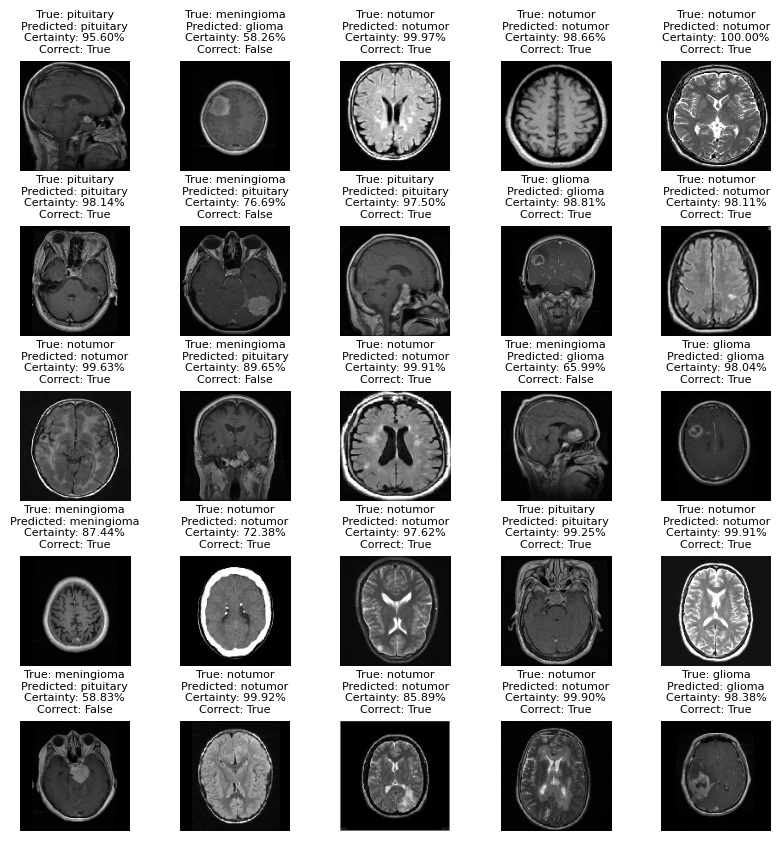

In [25]:
# Demonstration of a 10 by 10 grid with predictions and certainty

# Function to get predictions and probabilities
def predictAndPlot(model, paths, labels, n_samples=100):
    plt.figure(figsize=(10, 10))
    for i in range(min(n_samples, len(paths))):
        index = random.randint(0, len(paths)-1)
        image_path = paths[index]
        true_label = labels[index]
        
        image = load_img(image_path, target_size=(imageSize, imageSize))
        image_array = np.array([augmentImages(image)])
        plt.subplots_adjust(hspace=0.5)

        prediction_probabilities = model.predict(image_array)[0];
        predicted_label_index = np.argmax(prediction_probabilities);
        predicted_label = uniqueLables[predicted_label_index];
        certainty = prediction_probabilities[predicted_label_index] * 100;
        correct = true_label == predicted_label;
        
        plt.subplot(5, 5, i+1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}\nCertainty: {certainty:.2f}%\nCorrect: {correct}', fontsize=8)

# Call the function to plot the demonstration
predictAndPlot(model, testPaths, testLables, n_samples=25);
plt.show()


In [26]:
import tensorflow as tf

38/38 [==============================] - 39s 1s/step


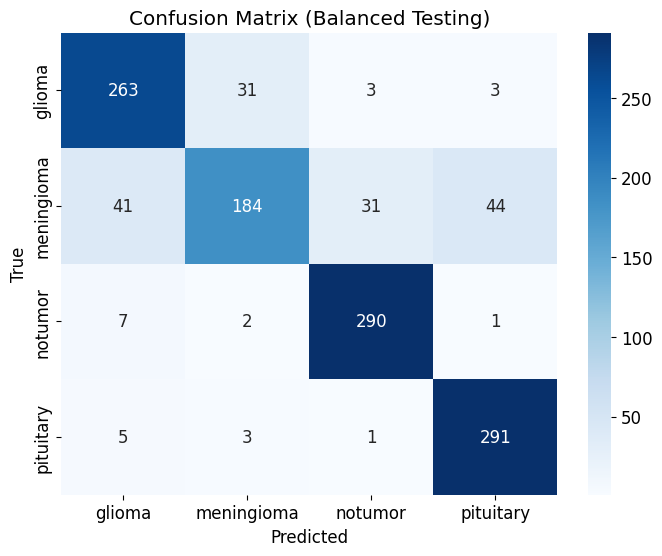

In [30]:
min_samples_per_class = min([testLables.count(label) for label in uniqueLables])
balanced_testPaths = []
balanced_testLables = []

for label in uniqueLables:
    class_paths = [path for path, lbl in zip(testPaths, testLables) if lbl == label]
    balanced_testPaths.extend(class_paths[:min_samples_per_class])
    balanced_testLables.extend([label] * min_samples_per_class)


test_images_balanced = openImages(balanced_testPaths)
testLables_encoded_balanced = encodeLables(balanced_testLables)

predictions_balanced = model.predict(test_images_balanced)
predicted_labels_balanced = np.argmax(predictions_balanced, axis=1)

confusion_matrix_balanced = tf.math.confusion_matrix(testLables_encoded_balanced, predicted_labels_balanced, num_classes=len(uniqueLables))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_balanced, annot=True, fmt='d', cmap='Blues', xticklabels=uniqueLables, yticklabels=uniqueLables)
plt.title('Confusion Matrix (Balanced Testing)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


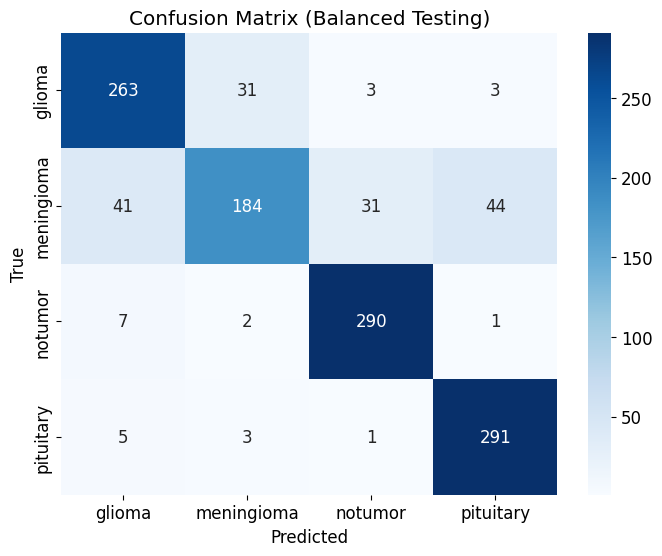

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_balanced, annot=True, fmt='d', cmap='Blues', xticklabels=uniqueLables, yticklabels=uniqueLables)
plt.title('Confusion Matrix (Balanced Testing)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [33]:
# Calculate Accuracy for Balanced Testing

accuracy_balanced = np.sum(np.diag(confusion_matrix_balanced)) / np.sum(confusion_matrix_balanced)
print(f"Accuracy on Balanced Testing (100 samples): {accuracy_balanced:.2%}")


Accuracy on Balanced Testing (100 samples): 85.67%


In [2]:
# def prd(imagePath):
#     img = tf.keras.preprocessing.image.load_img(imagePath, target_size=(28, 28), color_mode='grayscale')
#     imgArray = tf.keras.preprocessing.image.img_to_array(img)
#     imgArray = tf.expand_dims(imgArray, 0)  # Create batch axis
#     immArray = imgArray / 255.0  # Normalize pixel values

#     predictions = model.predict(imgArray)
    

#     return predictions

def prd(imagePath):
    return("80")

In [9]:
from flask import Flask, render_template, request
import os

app = Flask(__name__)

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/upload', methods=['POST'])
def uploadFile():
    if request.method == 'POST':
        uploadedFile = request.files['file']
        if uploadedFile:
            tempDir = os.path.join(os.path.dirname(__file__), 'temp')
            if not os.path.exists(tempDir):
                os.makedirs(tempDir)
            uploadedFile.save(os.path.join(tempDir, uploadedFile.filename))
            return 'File uploaded successfully!'
        else:
            return 'No file uploaded'

app.run(host='0.0.0.0', port=80)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:80
 * Running on http://192.168.7.32:80
Press CTRL+C to quit


In [8]:
%tb

SystemExit: 1